# Hackathon #5

Written by Eleanor Quint

Modified by Mrinal Rawool

Topics:
- Batch Normalization
- Residual architectures

This is all setup in a IPython notebook so you can run any code you want to experiment with. Feel free to edit any cell, or add some to run your own code.

In [1]:
# We'll start with our library imports...
from __future__ import print_function

import numpy as np                 # to use numpy arrays
import tensorflow as tf            # to specify and run computation graphs
import tensorflow_datasets as tfds # to load training data
import matplotlib.pyplot as plt    # to visualize data and draw plots
from tqdm import tqdm              # to track progress of loops

DATA_DIR = './tensorflow-datasets/'

#### Batch Normalization

During training, the `tf.keras.layers.BatchNormalization` layer normalizes its output using the mean and standard deviation of the current batch of inputs.


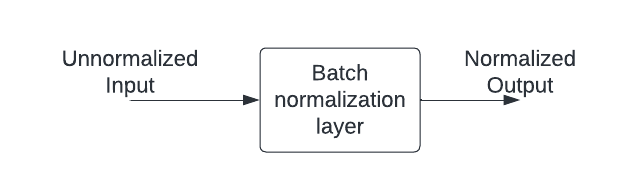


That is to say, for each channel being normalized, the layer returns $(batch - mean(batch)) / (var(batch) + \epsilon) * \gamma + \beta$, where:

- $\epsilon$ is small constant
- $\gamma$ is a learned scaling factor (initialized as 1), which can be disabled by passing scale=False to the constructor
- $\beta$ is a learned offset factor (initialized as 0), which can be disabled by passing center=False to the constructor



In [2]:
# Let's create some shifted data (i.e with a non zero mean and SD)
shifted_data = tf.random.normal(shape=[64], mean=-1.8, stddev=4.3)
print("Shifted/scaled statistics:", tf.math.reduce_mean(shifted_data).numpy(), tf.math.reduce_std(shifted_data).numpy())

Shifted/scaled statistics: -0.57105845 4.179091


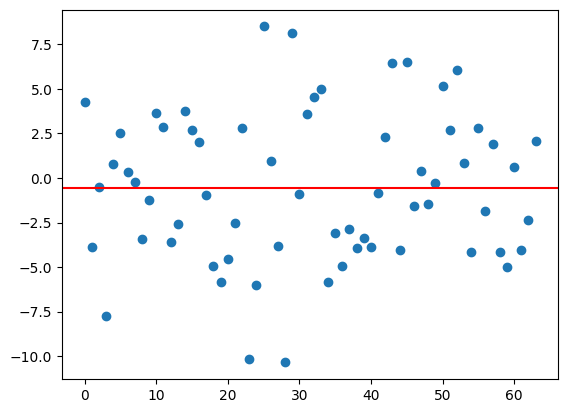

In [3]:
import matplotlib.pyplot as plt

plt.scatter(np.arange(64), shifted_data)
#add horizontal average line
plt.axhline(y=np.nanmean(shifted_data), c="red")
#see the plot
plt.show()

Training batch normd statistics: 0.0 0.0


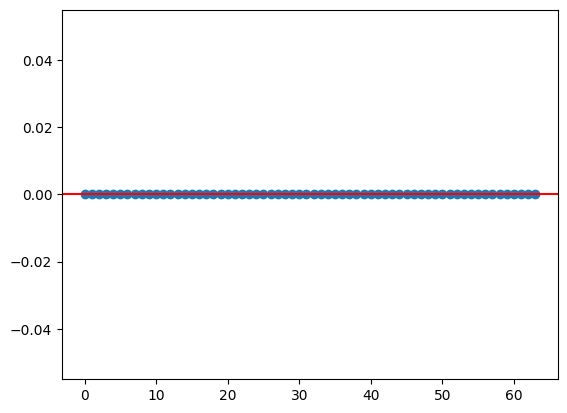

In [4]:
# Only create the variable if it doesn't exist
if 'batch_norm' not in locals():
    batch_norm = tf.keras.layers.BatchNormalization()

# This will always surely
normd_data = batch_norm(shifted_data, training=True)
print("Training batch normd statistics:",
      tf.math.reduce_mean(normd_data).numpy(), tf.math.reduce_std(normd_data).numpy())

plt.scatter(np.arange(64), normd_data)
#add horizontal average line
plt.axhline(y=np.nanmean(normd_data), c="red")
#see the plot
plt.show()

In [5]:
# This is what the BN layer uses for normalization during inference time
print("Moving mean:", tf.reduce_mean(batch_norm.moving_mean).numpy(),
      "Moving variance:", tf.reduce_mean(batch_norm.moving_variance).numpy())
# compare with input data mean:-0.80648726 SD: 4.554053

Moving mean: -0.0057105846 Moving variance: 0.99


In [6]:
# The first time this cell is run, the statistics will be almost identical to the original data
# The 100th time this cell is run, it should be close to the statistics of the normalized data (i.e., 0 mean and 0 std)
inference_normd_data = batch_norm(shifted_data, training=False)
print("Inference batch normd statistics:",
      tf.math.reduce_mean(inference_normd_data).numpy(), tf.math.reduce_std(inference_normd_data).numpy())


Inference batch normd statistics: -0.56790924 4.1560445


**Why is the output mean and SD non zero?**

During inference (when calling the layer/model with the argument training=False (which is the default)), the layer normalizes its output using a moving average of the mean and standard deviation of the batches it has seen during training. That is to say, it returns

(batch - self.moving\_mean) / (self.moving\_var + $\epsilon) * \gamma + \beta$

self.moving_mean and self.moving_var are non-trainable variables that are updated each time the layer in called in training mode, as such:

```
moving_mean = moving_mean * momentum + mean(batch) * (1 - momentum)
moving_var = moving_var * momentum + var(batch) * (1 - momentum)
```

As such, the layer will only normalize its inputs during inference after having been trained on data that has similar statistics as the inference data.

Let's demonstrate how this works:

### Demo

In [7]:
shifted_data = tf.random.normal(shape=[64], mean=-1.8, stddev=4.3, seed = 11)
print("Shifted/scaled statistics:",
      tf.math.reduce_mean(shifted_data).numpy(), tf.math.reduce_std(shifted_data).numpy())

batch_norm_1 = tf.keras.layers.BatchNormalization()

bnl_moving_mean = []
bnl_moving_var = []

# try for 10 iters and examine the plots below. Then try for higher # iters
for i in range(1000):
    normd_data = batch_norm_1(shifted_data, training=True)
    bnl_moving_mean.append(tf.reduce_mean(batch_norm_1.moving_mean).numpy())
    bnl_moving_var.append(tf.reduce_mean(batch_norm_1.moving_variance).numpy())

# after 50 iterations:
inference_normd_data = batch_norm_1(shifted_data, training=False)
print("Inference batch normd statistics:",
      tf.math.reduce_mean(inference_normd_data).numpy(), tf.math.reduce_std(inference_normd_data).numpy())

Shifted/scaled statistics: -1.8100402 4.374397
Inference batch normd statistics: -0.002420172 0.0058542783


<ipython-input-8-f8306f2184cf>:4: UserWarning: You passed a edgecolor/edgecolors ('None') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axes[0].scatter(np.arange(64), shifted_data, marker='x', c='r', s=10, edgecolor='None')
<ipython-input-8-f8306f2184cf>:9: UserWarning: You passed a edgecolor/edgecolors ('None') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axes[1].scatter(np.arange(64), inference_normd_data, marker='x', c='b', s=10, edgecolor='None')


(-15.0, 11.0)

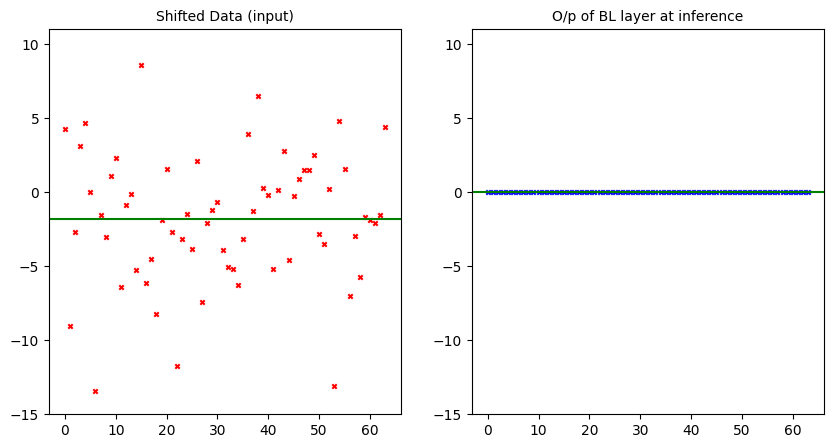

In [8]:
f, axes = plt.subplots(1, 2, sharex='col',  figsize=(10, 5))


axes[0].scatter(np.arange(64), shifted_data, marker='x', c='r', s=10, edgecolor='None')
axes[0].axhline(y=np.nanmean(shifted_data), c="g")
axes[0].set_title('Shifted Data (input)', fontsize=10)
axes[0].set_ylim(tf.math.ceil(min(shifted_data)).numpy()-2, tf.math.ceil(max(shifted_data)).numpy()+2)

axes[1].scatter(np.arange(64), inference_normd_data, marker='x', c='b', s=10, edgecolor='None')
axes[1].axhline(y=np.nanmean(inference_normd_data), c="g")
axes[1].set_title('O/p of BL layer at inference', fontsize=10)
axes[1].set_ylim(tf.math.ceil(min(shifted_data)).numpy()-2, tf.math.ceil(max(shifted_data)).numpy()+2)

Text(0.5, 1.0, 'BN layer moving mean v/s iterations')

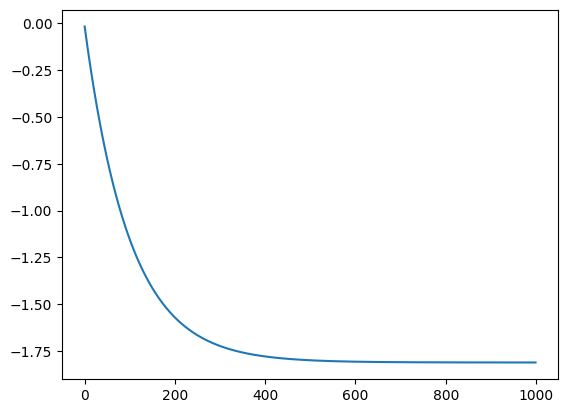

In [9]:
plt.plot(np.arange(1000), bnl_moving_mean) # 1000 = iters
axes[1].set_title('BN layer moving mean v/s iterations', fontsize=10)

Text(0.5, 1.0, 'BN layer moving var v/s iterations')

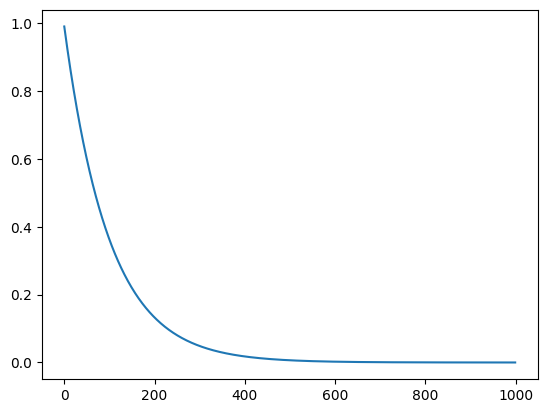

In [10]:
plt.plot(np.arange(1000), bnl_moving_var) # 1000 = iters
axes[1].set_title('BN layer moving var v/s iterations', fontsize=10)

Batch normalization is usually pretty unnecessary in smaller networks. It's main purpose is to make training deeper networks faster and easier. Once batch normalization was introduced, much work went into designing deeper and more effective architectures. Two examples from ResNet are below. These are called residual architectures, so called because they compute a residual value $f(x)$ to add to the input value of the representation $x$.

<div>
<img src="attachment:resnet-e1548261477164.png" width="500"/>
</div>

The first example is a standard "ResNet Block", which is still in wide use.

### Residual Block

In [11]:
class ResBlock(tf.Module):

    def __init__(self, filter_num, stride=1):
        super().__init__()
        self.stride = stride

        # Both self.conv1 and self.down_conv layers downsample the input when stride != 1
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.conv1 = tf.keras.layers.Conv2D(filters=filter_num,
                                            kernel_size=(3, 3),
                                            strides=stride,
                                            padding="same")
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv2D(filters=filter_num,
                                            kernel_size=(3, 3),
                                            padding="same")

        if self.stride != 1:
            self.down_conv = tf.keras.layers.Conv2D(filters=filter_num,
                                                    kernel_size=(1, 1),
                                                    strides=stride,
                                                    padding="same")
            self.down_bn = tf.keras.layers.BatchNormalization()

    def __call__(self, x, is_training):
        identity = x
        if self.stride != 1:
            identity = self.down_conv(identity)
            identity = self.down_bn(identity, training=is_training)

        x = self.bn1(x, training=is_training)
        x = tf.nn.relu(x)
        x = self.conv1(x)


        x = self.bn2(x, training=is_training)
        x = tf.nn.relu(x)
        x = self.conv2(x)

        return x + identity

For non-residual, non-nested function classes, a larger (indicated by area) function class does not guarantee to get closer to the “truth” function $f^*$. This does not happen in nested function classes, like a residual network.

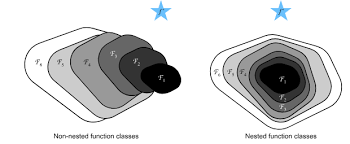

When building a network out of these blocks, ideally, a convolutional layer or two would preceed the ResNet blocks to get the number of channels in the representation to be large enough to carry a significant amount of information (typically 32 or 64). Then, to downscale the height and width of the data, every few blocks, the stride is set to 2 while the number of channels is multiplied by 2.

Another block that can be used in very very deep networks (this was introduced for 100 layers or more networks originally) is the Bottleneck layer.

### Bottleneck Layer

In [12]:
EXPANSION_FACTOR = 4

class Bottleneck(tf.Module):

    def __init__(self, filter_num, stride=1):
        super(Bottleneck, self).__init__()
        self.stride = stride
        assert filter_num % EXPANSION_FACTOR == 0

        self.conv1 = tf.keras.layers.Conv2D(filter_num // EXPANSION_FACTOR, kernel_size=1, padding='same')
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv2D(filter_num // EXPANSION_FACTOR, kernel_size=3, strides=stride, padding='same')
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.conv3 = tf.keras.layers.Conv2D(filter_num, kernel_size=1, padding='same')
        self.bn3 = tf.keras.layers.BatchNormalization()

        if self.stride != 1:
            self.down_conv = tf.keras.layers.Conv2D(filters=filter_num,
                                                    kernel_size=(1, 1),
                                                    strides=stride,
                                                    padding="same")
            self.down_bn = tf.keras.layers.BatchNormalization()

    def __call__(self, x, is_training):
        identity = x
        if self.stride != 1:
            identity = self.down_conv(identity)
            identity = self.down_bn(identity, training=is_training)

        x = self.bn1(x)
        x = tf.nn.relu(x)
        x = self.conv1(x)

        x = self.bn2(x)
        x = tf.nn.relu(x)
        x = self.conv2(x)

        x = self.bn3(x)
        x = tf.nn.relu(x)
        x = self.conv3(x)

        return x + identity

### Homework

In [13]:
class ResnetIdentityBlock(tf.keras.Model):
    def __init__(self, kernel_size, filters):
    super(ResnetIdentityBlock, self).__init__(name='csce479-879')
    filters1, filters2, filters3 = filters

    self.conv2a = tf.keras.layers.Conv2D(filters1, (1, 1))
    self.bn2a = tf.keras.layers.BatchNormalization()

    self.conv2b = tf.keras.layers.Conv2D(filters2, kernel_size, padding='same')
    self.bn2b = tf.keras.layers.BatchNormalization()

    self.conv2c = tf.keras.layers.Conv2D(filters3, (1, 1))
    self.bn2c = tf.keras.layers.BatchNormalization()

  def call(self, input_tensor, training):
    x = self.conv2a(input_tensor)
    x = self.bn2a(x, training=training)
    x = tf.nn.relu(x)

    x = self.conv2b(x)
    x = self.bn2b(x, training=training)
    x = tf.nn.relu(x)

    x = self.conv2c(x)
    x = self.bn2c(x, training=training)

    x += input_tensor
    return tf.nn.relu(x)

### Homework

Please do two things for this one:
1. Write a few sentences about the differences between the `ResBlock` and `Bottleneck` layers above. Why might the Bottleneck block be more suitable for deeper architectures with more layers?
2. Call the ```ResnetIdentityBlock``` given above using an image dataset and print the summary. You can use the 'cifar10' dataset from Hackathon 4 and reuse code from that notebook for this assignment.
Sample code for printing the summary from Hackathon4:
```
for batch in train_ds:
    # data is uint8 by default, so we have to cast it
    conv_classifier(tf.cast(batch['image'], tf.float32))
    break
conv_classifier.summary()
```
You may use [this link](https://www.tensorflow.org/tutorials/customization/custom_layers#models_composing_layers) as a reference.


On Canvas, submit
1. your python code in a `.py` and
2. your short write-up for Part 1 and a screenshot of the summary for Part 2 as a **.pdf**

I'm expecting this to take about an hour (or less if you're experienced). Feel free to use any code from this or previous hackathons. If you don't understand how to do any part of this or if it's taking you longer than that, please let me know in office hours or by email (both can be found on the syllabus). I'm also happy to discuss if you just want to ask more questions about anything in this notebook!